# **필요한 라이브러리 불러오기**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

# **MNIST 데이터셋 불러오기**
- 60,000개의 train data, 10,000개의 test data

In [2]:
# GPU로 연산.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정.
# 실험 조건을 동일하게 설정하여,
# 같은 input을 넣으면 같은 결과가 나올 수 있도록 함.
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# MNIST dataset
# 60,000개의 train data, 10,000개의 test data
mnist_train = torchvision.datasets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = torchvision.datasets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [4]:
# dataset 크기 출력
print(len(mnist_train))
print(len(mnist_test))

60000
10000


# **Data Augmentation**

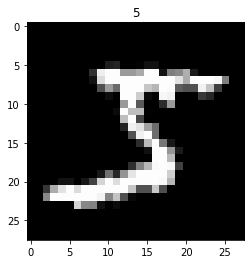

In [5]:
# random affine 적용후 데이터 시각화
plt.imshow(torchvision.transforms.RandomAffine((10,30))(to_pil_image(mnist_train.data[0])), cmap='gray')
plt.title('%s' % mnist_train[0][1])
plt.show()

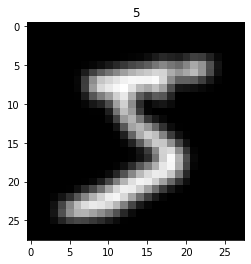

In [6]:
# blur 적용후 데이터 시각화
plt.imshow(transforms.GaussianBlur(kernel_size=3)(to_pil_image(mnist_train.data[0])), cmap='gray')
plt.title('%s' % mnist_train[0][1])
plt.show()

In [7]:
#  Random Affinement, GaussianBlur을 적용한 버전의 데이터셋 다운로드

train_transforms = transforms.Compose(
    [
     transforms.RandomAffine(degrees=(10,30)),
     transforms.GaussianBlur(kernel_size=3),
     transforms.ToTensor()
     ])

augmented_data = torchvision.datasets.MNIST(root='MNIST_data/',
                                        train=True,
                                        transform=train_transforms,
                                        download=True)

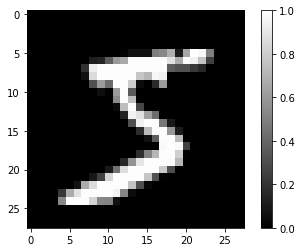

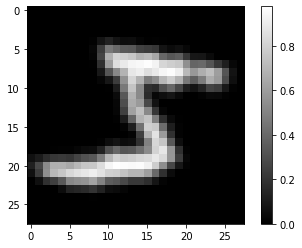

In [8]:
# original 이미지와 augmented 이미지 비교

im = mnist_train[0][0][0]
aug_im = augmented_data[0][0][0]

# Normal image
plt.imshow(im, cmap="gray")
plt.colorbar()
plt.show()

# Agumented image
plt.imshow(aug_im, cmap="gray")
plt.colorbar()
plt.show()

In [9]:
# augmented_data의 일부만 사용
idx = range(0,20000)
train_subset = torch.utils.data.Subset(augmented_data, idx)

# original dataset과 합친 dataset 생성
train_dataset = torch.utils.data.ConcatDataset([train_subset,mnist_train])

# 합쳐진 dataset 크기 출력
print(len(train_dataset))

80000


In [10]:
batch_size = 128        # 배치크기

# Data loader를 사용하여 배치 크기 지정
train_loader=torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False)

# **모델 설계**
- MLP witih dropout

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # input_layer = 28*28, hidden_layer1 = 512
        self.fc1 = nn.Linear(28*28, 512)
        # hidden_layer1 = 512, hidden_layer2 = 512
        self.fc2 = nn.Linear(512,512)
        # # hidden_layer2 = 512, hidden_layer3 = 10
        self.fc3 = nn.Linear(512,10)
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.view(-1,28*28)  # flatten 
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x

In [13]:
model = Net().to(device)   # GPU에서 연산 수행하기 위해 device로 보냄

In [14]:
# 모델 구성 출력
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


# **Train**

In [15]:
epochs = 15             # 학습 횟수
learning_rate = 0.01    # 학습률

In [16]:
# cost function과 optimizer 정의
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [17]:
# 모델 학습
model.train()
loss_list = []

for epoch in range(epochs):
  avg_loss = 0.0
  total_loss = 0.0
  for iter, data in enumerate(train_loader):
    optimizer.zero_grad()
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
    total_loss += loss.item()

    if (iter+1) % 100==0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.5f}'.format(
      epoch, iter+1, len(train_loader), avg_loss/100.)) # 케이스 100개 마다 평균 loss 출력
      avg_loss = 0.0
  loss_list.append(total_loss/(iter+1)) #epoch마다 평균 loss를 loss_list에 추가 
print('\nLearning finished!')

Train Epoch: 0 [100/625]	Loss: 2.28102
Train Epoch: 0 [200/625]	Loss: 2.23602
Train Epoch: 0 [300/625]	Loss: 2.16356
Train Epoch: 0 [400/625]	Loss: 2.03492
Train Epoch: 0 [500/625]	Loss: 1.83734
Train Epoch: 0 [600/625]	Loss: 1.57315
Train Epoch: 1 [100/625]	Loss: 1.24941
Train Epoch: 1 [200/625]	Loss: 1.05072
Train Epoch: 1 [300/625]	Loss: 0.91302
Train Epoch: 1 [400/625]	Loss: 0.82465
Train Epoch: 1 [500/625]	Loss: 0.76685
Train Epoch: 1 [600/625]	Loss: 0.70117
Train Epoch: 2 [100/625]	Loss: 0.65897
Train Epoch: 2 [200/625]	Loss: 0.64101
Train Epoch: 2 [300/625]	Loss: 0.59377
Train Epoch: 2 [400/625]	Loss: 0.59378
Train Epoch: 2 [500/625]	Loss: 0.56378
Train Epoch: 2 [600/625]	Loss: 0.54020
Train Epoch: 3 [100/625]	Loss: 0.53267
Train Epoch: 3 [200/625]	Loss: 0.51516
Train Epoch: 3 [300/625]	Loss: 0.51999
Train Epoch: 3 [400/625]	Loss: 0.49216
Train Epoch: 3 [500/625]	Loss: 0.50496
Train Epoch: 3 [600/625]	Loss: 0.48442
Train Epoch: 4 [100/625]	Loss: 0.48698
Train Epoch: 4 [200/625]	

In [20]:
# # weights 다운로드
# !pip install gdown
# !gdown --id 1eqC3zwCImM4cgFf8jFMXSvZPCYG0Bdop

Downloading...
From: https://drive.google.com/uc?id=1eqC3zwCImM4cgFf8jFMXSvZPCYG0Bdop
To: /content/overfitting_Weights.pth
100% 2.68M/2.68M [00:00<00:00, 85.5MB/s]


# **Test**

In [ ]:
## weights를 load
# model.load_state_dict(torch.load('/content/overfitting_Weights.pth'))

In [21]:
# 모델 성능 확인
with torch.no_grad(): # torch.no_grad(): gradient 계산을 수행하지 않음
  model.eval()
  accuracy = 0.0

  for iter, data in enumerate(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    pred = torch.argmax(output,1) == labels
    accuracy += pred.float().sum() # batch마다 맞은 개수를 accuracy에 기록
    
  print("Accuracy : {:.2f}%".format(100*accuracy/len(mnist_test))) # accuracy를 총 test dataset 개수로 나눔

Accuracy : 94.00%
